In [1]:
import os
import random
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = (64, 64)
batch_size = 16
num_epochs = 6
learning_rate = 0.001
logos_csv = "dataset/logos.csv"
reference_logos_dir = "dataset/reference_logos"
df = pd.read_csv(logos_csv)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
def hardest_negative(anchor, positives, negatives, model):
    with torch.no_grad():
        anchor_embed = model(anchor.unsqueeze(0))
        # positive_embed = model(positives.unsqueeze(0))
        negative_embeds = torch.stack([model(n.unsqueeze(0)) for n in negatives])

        distances = torch.norm(anchor_embed - negative_embeds, dim=1)
        hardest_negative_idx = torch.argmin(distances)
        hardest_negative = negatives[hardest_negative_idx]

    return hardest_negative


In [5]:
class TripletLogoDataset(Dataset):
    def __init__(self, df, logos_dir, transform=None, model=None):
        self.df = df
        self.logos_dir = logos_dir
        self.transform = transform
        self.model = model
        self.brand_to_images = {
            brand: [f for f in os.listdir(os.path.join(logos_dir, brand)) if f.endswith((".jpg", ".png"))]
            for brand in os.listdir(logos_dir)
            if os.path.isdir(os.path.join(logos_dir, brand))
        }
        self.brands = list(self.brand_to_images.keys())

    def __len__(self):
        return sum(len(images) for images in self.brand_to_images.values())

    def __getitem__(self, idx):
        brand = random.choice(self.brands)
        images = self.brand_to_images[brand]

        anchor_file, positive_file = random.sample(images, 2)
        anchor_path = os.path.join(self.logos_dir, brand, anchor_file)
        positive_path = os.path.join(self.logos_dir, brand, positive_file)

        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)

        negative_brand = random.choice([b for b in self.brands if b != brand])
        negative_files = self.brand_to_images[negative_brand]
        negative_images = [Image.open(os.path.join(self.logos_dir, negative_brand, f)).convert("RGB") for f in
                           negative_files]

        if self.transform:
            negative_images = [self.transform(img) for img in negative_images]

        if self.model:
            negative = hardest_negative(anchor, positive, negative_images, self.model)
        else:
            negative = random.choice(negative_images)

        return anchor, positive, negative, brand


In [6]:
dataset = TripletLogoDataset(df, reference_logos_dir, transform=train_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256)
        )

    def forward(self, x):
        return self.cnn(x)

In [8]:
class TripletLoss(nn.Module):
    def __init__(self):
        super(TripletLoss, self).__init__()
        self.loss_fn = nn.SoftMarginLoss()

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        target = torch.ones_like(distance_positive)
        loss = self.loss_fn(distance_negative - distance_positive, target)
        return loss


In [9]:
model = EmbeddingNet().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [10]:
def evaluate_model():
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for anchor, positive, negative, brand in test_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            test_loss += loss.item()

            similarities = cosine_similarity(anchor_embed.cpu().numpy(), positive_embed.cpu().numpy())
            predicted = np.argmax(similarities, axis=1)
            correct += np.sum(predicted == np.arange(len(predicted)))
            total += len(predicted)

    accuracy = (correct / total) * 100
    return test_loss / len(test_loader), accuracy

In [11]:
def train_model():
    train_losses = []
    test_losses = []
    accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for anchor, positive, negative, _ in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        test_loss, accuracy = evaluate_model()
        test_losses.append(test_loss)
        accuracy_list.append(accuracy)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, accuracy_list

In [ ]:
train_losses, test_losses, accuracy_list = train_model()

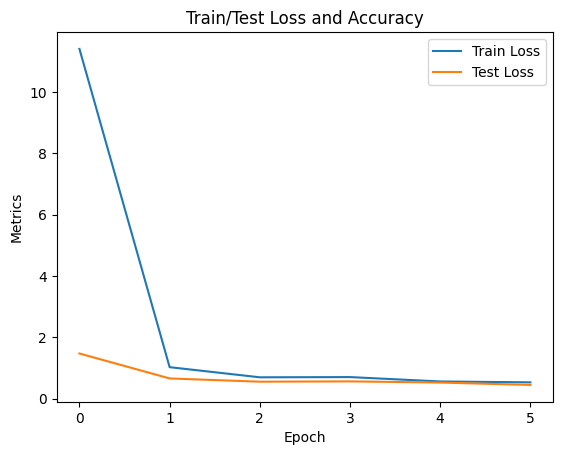

In [110]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
# plt.plot(accuracy_list, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Train/Test Loss and Accuracy")
plt.legend()
plt.show()

In [111]:
torch.save(model.state_dict(), "logo_model.pth")

In [115]:
def load_reference_embeddings(model, ref_dir):
    model.eval()
    embeddings = {}

    for brand in os.listdir(ref_dir):
        brand_dir = os.path.join(ref_dir, brand)
        for img_name in os.listdir(brand_dir):
            img_path = os.path.join(brand_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            image = train_transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                embeddings[img_name] = model(image).cpu().numpy()

    return embeddings

In [116]:
def predict_brand(model, test_image, ref_embeddings):
    model.eval()
    image = Image.open(test_image).convert("RGB")
    image = train_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        query_embedding = model(image).cpu().numpy()

    similarities = {k: cosine_similarity(query_embedding, v)[0][0] for k, v in ref_embeddings.items()}
    best_match = max(similarities, key=similarities.get)
    return best_match, similarities[best_match]


In [119]:
embedding_model = EmbeddingNet().to(device)
embedding_model.load_state_dict(torch.load("logo_model.pth", weights_only=True))

<All keys matched successfully>

In [120]:
reference_embeddings = load_reference_embeddings(embedding_model, reference_logos_dir)
test_image = "openLogo/JPEGImages/uniqlo8.jpg"
predicted_brand, score = predict_brand(embedding_model, test_image, reference_embeddings)
print(f"Predicted Brand: {predicted_brand}, Similarity Score: {score:.4f}")

Predicted Brand: nescafeimg000081.jpg, Similarity Score: 0.9222
